## **PRACTICAL SESSION 1** — Deep Learning for predictive maintenance

The dataset used is the **AI4I 2020** Predictive Maintenance Dataset, which contains 10,000 instances of industrial sensor data. Each instance represents the operating condition of a machine and is associated with a label indicating whether a failure has occurred and, if so, what type of failure it is.

The 5 possible labels are:



*   **TWF**: Tool Wear Failure
*   **HDF**: Heat Dissipation Failure
*   **PWF**: Power Failure
*   **OSF**: Overstrain Failure
*   **RNF**: Random Failure


The data is available on eCAMPUS as CSV file called: "ai4i2020.csv"



## **PRACTICAL SESSION Goal** — Ceate a deep leanring model allowing to realize a predictive maintenance mission

## **1 - Analysis of the dataset**



All libraries used ***SHOULD BE PLACED*** in the code cell below

In [30]:
!pip install tensorflow==2.12.0

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from imblearn.under_sampling import RandomUnderSampler


**QUESTION:** Load dataset and display some lines of the csv file.

In [31]:
data_path = "/content/ai4i2020.csv"

df = pd.read_csv(data_path)

df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


**QUESTION:** Display the distribution of machine failures and non-failures with a bar graph.

<ipython-input-32-af8817148363>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Failure Status', y='Count', data=plot_df, palette=["green", "red"])


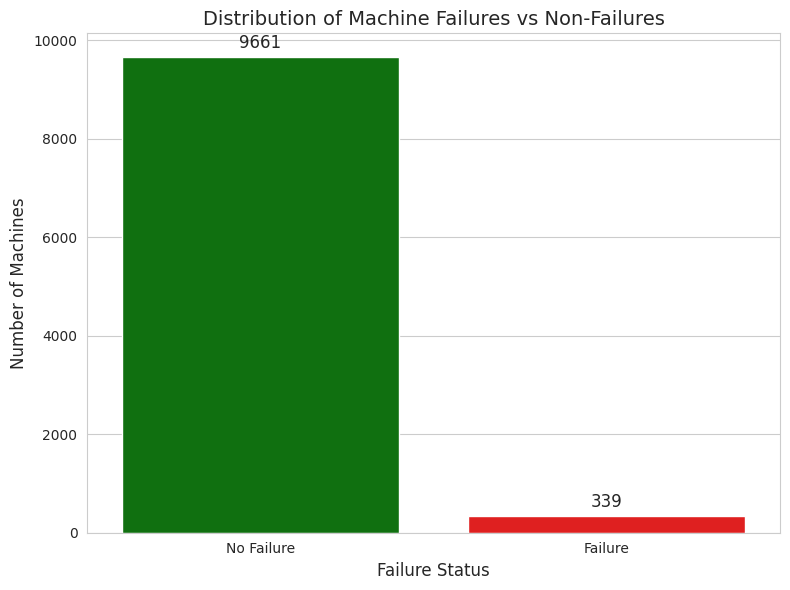

In [32]:
# Count how many machines failed and how many didn't fail
failure_counts = df['Machine failure'].value_counts()

labels = ['No Failure', 'Failure']
values = [failure_counts.get(0, 0), failure_counts.get(1, 0)]

plot_df = pd.DataFrame({
    'Failure Status': labels,
    'Count': values
})

plt.figure(figsize=(8, 6))

sns.set_style("whitegrid")

ax = sns.barplot(x='Failure Status', y='Count', data=plot_df, palette=["green", "red"])

for i, value in enumerate(values):
    plt.text(i, value + max(values)*0.01, str(value), ha='center', va='bottom', fontsize=12)

plt.title("Distribution of Machine Failures vs Non-Failures", fontsize=14)
plt.xlabel("Failure Status", fontsize=12)
plt.ylabel("Number of Machines", fontsize=12)

plt.tight_layout()

plt.show()

**ANALYSIS QUESTION:** What do you observe?

The system has a low percentage of faults (3.39 %).


**ANALYSIS QUESTION:** What will be the consequence of this phenomenon on the model's learning?

As the data is not well distributed between failure and non-failure, the model will probably tend to choose the non-failure label, because even if it is wrong, the high number of non-failure samples will indicate a low error, even if this is not true.

**QUESTION:** Create a bar chart showing the distribution of different failure types (TWF, HDF, PWF, OSF, RNF). Display the exact values above each bar in the chart."

<ipython-input-33-86f12764d805>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=failure_counts.index, y=failure_counts.values, palette=['orange', 'green', 'purple', 'red', 'blue'])


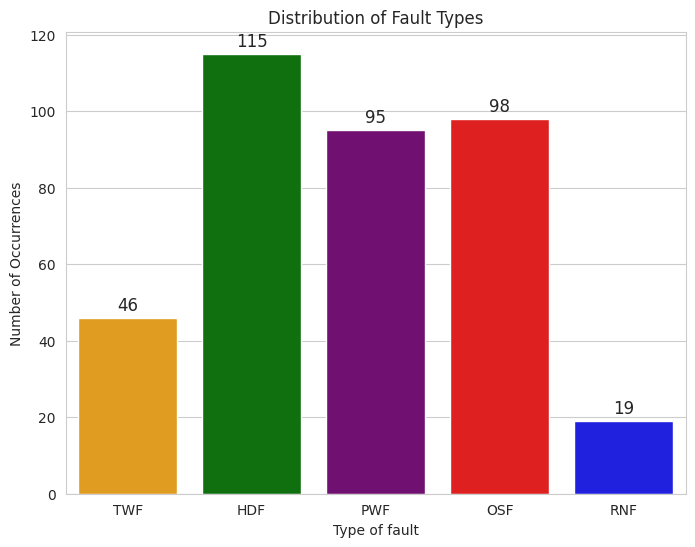

In [33]:
# Defines fault types
failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']

# Sum the number of occurrences of each type of fault
failure_counts = df[failure_types].sum()

plt.figure(figsize=(8, 6))

ax = sns.barplot(x=failure_counts.index, y=failure_counts.values, palette=['orange', 'green', 'purple', 'red', 'blue'])

for i, value in enumerate(failure_counts.values):
    ax.text(i, value + 2, str(value), ha='center', fontsize=12)

plt.xlabel("Type of fault")
plt.ylabel("Number of Occurrences")
plt.title("Distribution of Fault Types")

plt.show()

**ANALYSIS QUESTION:** What do you observe?

It can be seen that there is a greater occurrence of HDF, PWF and OSF faults than TWF and RNF faults. It is worth noting that the sum of the faults of each type gives a total of 373 faults, although as seen in the first graph ("Distribution of Faults and Non-Faults in the Machine") there are a total of 339 faults. This is because certain machines have simultaneous faults, and random faults (RNF) are not counted as faults.

**QUESTION:** Create a bar chart showing the distribution of failure types (TWF, HDF, PWF, OSF, RNF) among machines that experienced a failure (Machine failure == 1). Additionally, add a "No Specific Failure" category to count cases where a machine failed but no specific failure type was recorded. Display the exact values above each bar in the chart."

<ipython-input-34-394b9113869b>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=failure_counts.index, y=failure_counts.values,  palette=['orange', 'green', 'purple', 'red', 'blue', 'gray'])


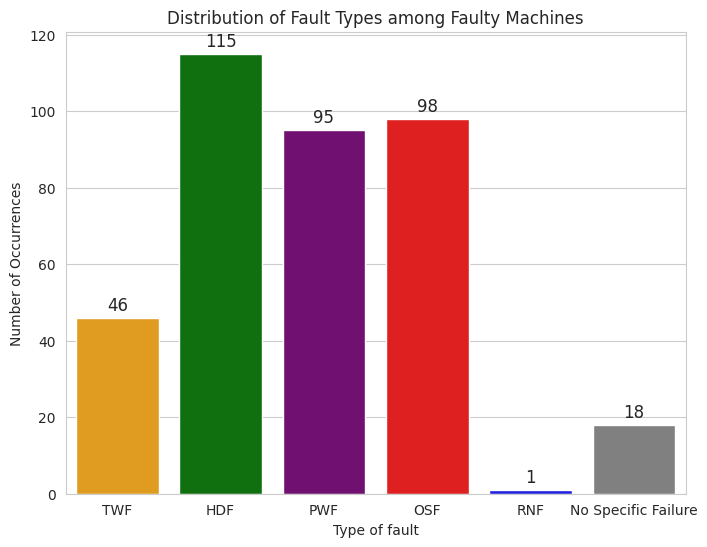

In [34]:
# Filters only the machines that have failed
failed_machines = df[df["Machine failure"] == 1]

failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']

failure_counts = failed_machines[failure_types].sum()

# Counts how many machines have not failed, but have RNF = 1 (non-specific failure)
no_specific_failure = df[(df["Machine failure"] == 0) & (df["RNF"] == 1)].shape[0]

failure_counts["No Specific Failure"] = no_specific_failure

plt.figure(figsize=(8, 6))

ax = sns.barplot(x=failure_counts.index, y=failure_counts.values,  palette=['orange', 'green', 'purple', 'red', 'blue', 'gray'])

for i, value in enumerate(failure_counts.values):
    ax.text(i, value + 2, str(value), ha='center', fontsize=12)

plt.xlabel("Type of fault")
plt.ylabel("Number of Occurrences")
plt.title("Distribution of Fault Types among Faulty Machines")

plt.show()

**ANALYSIS QUESTION:** What do you obsrve comapred to the previous question ? What can you conclude?

As already mentioned, random failures are not counted in the "Machine Failure" column, so the "No Specific Failure" bar was created to cover these cases. In the previous graph, 19 "RNF" failures were accounted for, however, in the current graph there are 18 "No Specific Failure" failures (which are "RNF" failures not accounted for) and 1 "RNF" failure, which was only accounted for because there is another simultaneous failure.

**QUESTION:** Display the names of the different columns in the dataset with their respective data types.

In [35]:
df.dtypes

,0
UDI,int64
Product ID,object
Type,object
Air temperature [K],float64
Process temperature [K],float64
Rotational speed [rpm],int64
Torque [Nm],float64
Tool wear [min],int64
Machine failure,int64
TWF,int64


**ANALYSIS QUESTION:** To train the model, what will be the inputs and outputs (What are the names of the columns that you will use?)? Justify your response.
Remember, you want to predict if the machine will fail, and if so, what kind of failure. You need to yse previous results to jsurtify your response.

To train the model, the inputs chosen will be the variables that indicate the use of the machine and its physical situation, such as Air temperature, Process temperature, Rotational speed, Torque, Tool wear and Type, as they directly influence performance and possible failures. The outputs
will be Machine failure and the columns with the types of failure such as TWF, HDF, PWF and OSF. RNF type failures will not be used to train the model because they refer to random failures, and there is no way of predicting this type of random failure.

## **2- Train model Without balancing the dataset**

---



In this section, you must build and train a model without rebalancing the dataset.

**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [36]:
# Converts to coluna 'Type' (one-hot encoding)
df = pd.get_dummies(df, columns=['Type'], drop_first=False)

# List of specific fault types
failure_types = ['TWF', 'HDF', 'PWF', 'OSF']

# Creates a column with the sum of failures per row
df['sum_failures'] = df[failure_types].sum(axis=1)

# Maintains only machines without a fault or with a single specific fault
df = df[(df['Machine failure'] == 0) | ((df['Machine failure'] == 1) & (df['sum_failures'] == 1))]

# Removes the auxiliary sum column
df.drop(columns='sum_failures', inplace=True)

# Creates a 'No failure' column
df['No failure'] = (df['Machine failure'] == 0).astype(int)

# Define Y with as classes
Y = df[['No failure', 'TWF', 'HDF', 'PWF', 'OSF']].copy()

# Ensures that Y is binarized
Y = Y.apply(lambda row: (row == 1).astype(int), axis=1)

df = df.drop(columns=['class'], errors='ignore')
X = df.drop(columns=['UDI', 'Product ID', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'No failure'])

# Normalizes input data between 0 and 1
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

# Dividir os dados em treinamento e teste
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42, stratify=Y.values.argmax(axis=1)
)

print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

print(Y_train.head())
print(X_train.head())

X_train shape: (6977, 8), Y_train shape: (6977, 5)
X_test shape: (2991, 8), Y_test shape: (2991, 5)
      No failure  TWF  HDF  PWF  OSF
5781           1    0    0    0    0
8589           1    0    0    0    0
832            1    0    0    0    0
5331           1    0    0    0    0
7660           1    0    0    0    0
      Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
5760             0.695652                 0.666667                0.261932   
8562             0.217391                 0.259259                0.215367   
831              0.141304                 0.209877                0.205471   
5313             0.913043                 0.876543                0.162980   
7634             0.565217                 0.728395                0.045402   

      Torque [Nm]  Tool wear [min]  Type_H  Type_L  Type_M  
5760     0.451923         0.458167     0.0     0.0     1.0  
8562     0.607143         0.681275     0.0     0.0     1.0  
831      0.478022         





**QUESTION** Code below the model architecture

In [37]:
# Define the sequential model
model = Sequential([
    # First dense layer with L2 regularization
    Dense(64, kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1],)),
    BatchNormalization(),          # Normalizes the data from the previous layer
    LeakyReLU(),                   # Activation function that allows small negative values
    Dropout(0.3),                  # Deactivates 30% of neurons

    # Second layer with fewer neurons
    Dense(32, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.4),

    # Output layer with 5 neurons and softmax activation
    Dense(5, activation='softmax')
])

model.compile(
    optimizer=AdamW(learning_rate=0.001, weight_decay=0.02),
    loss='categorical_crossentropy',          # Used for multi-class classification
    metrics=['accuracy']
)

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                576       
                                                                 
 batch_normalization_6 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 64)                0         
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_7 (Batc  (None, 32)               128       
 hNormalization)                                      

**QUESTION** Code below the algorithms allowing to train model

**WARNING!** You need to plot the training and test accuracy and loss to check if our model is overfitting

Epoch 1/50
110/110 [==============================] - 5s 13ms/step - loss: 1.9186 - accuracy: 0.4694 - val_loss: 1.4577 - val_accuracy: 0.9692 - lr: 0.0010
Epoch 2/50
110/110 [==============================] - 1s 7ms/step - loss: 0.8613 - accuracy: 0.9071 - val_loss: 0.7682 - val_accuracy: 0.9692 - lr: 0.0010
Epoch 3/50
110/110 [==============================] - 1s 7ms/step - loss: 0.5678 - accuracy: 0.9506 - val_loss: 0.4591 - val_accuracy: 0.9692 - lr: 0.0010
Epoch 4/50
110/110 [==============================] - 1s 9ms/step - loss: 0.4353 - accuracy: 0.9593 - val_loss: 0.3285 - val_accuracy: 0.9692 - lr: 0.0010
Epoch 5/50
110/110 [==============================] - 1s 13ms/step - loss: 0.3405 - accuracy: 0.9632 - val_loss: 0.2696 - val_accuracy: 0.9692 - lr: 0.0010
Epoch 6/50
110/110 [==============================] - 1s 13ms/step - loss: 0.2896 - accuracy: 0.9633 - val_loss: 0.2341 - val_accuracy: 0.9692 - lr: 0.0010
Epoch 7/50
110/110 [==============================] - 1s 9ms/step -

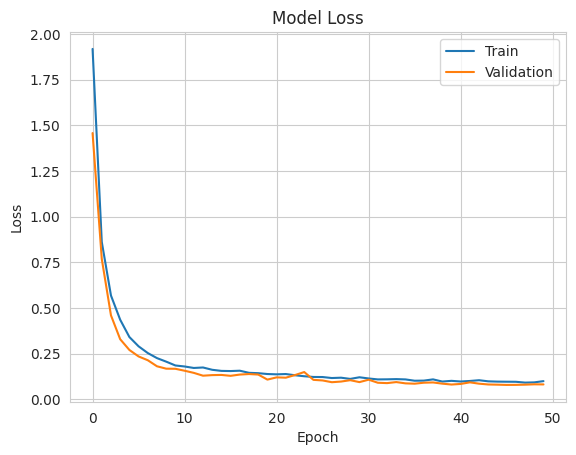

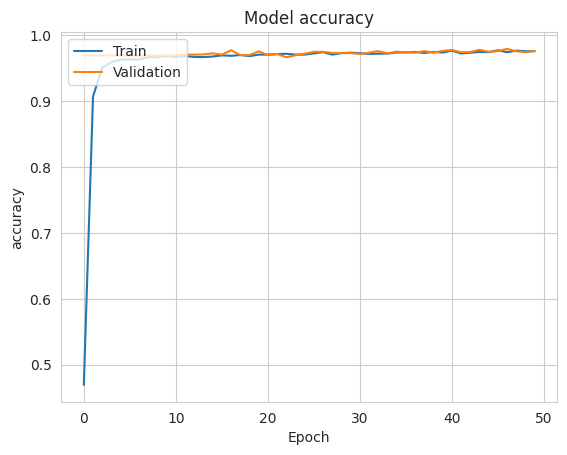

In [38]:
# Callbacks
# Stop training if validation does not improve
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Reduces learning rate by half if validation loss does not improve
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1)

# Train the model
history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

def plot_metric(history, metric, title, ylabel, loc='upper left'):
    if metric in history.history:
        plt.plot(history.history[metric], label='Train')
    if f'val_{metric}' in history.history:
        plt.plot(history.history[f'val_{metric}'], label='Validation')

    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend(loc=loc)
    plt.show()

plot_metric(history, 'loss', 'Model Loss', 'Loss', loc='upper right')

plot_metric(history, 'accuracy', 'Model accuracy', 'accuracy')

**QUESTION** Plot the confusion matrix and the classification report

**Tips:**

*   classification report link

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

*   Matrix confusion

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html





94/94 [==============================] - 0s 1ms/step

Relatório de Classificação:
              precision    recall  f1-score   support

  No failure       0.98      0.99      0.99      2899
         TWF       0.00      0.00      0.00        13
         HDF       0.39      0.22      0.28        32
         PWF       0.71      0.62      0.67        24
         OSF       0.86      0.78      0.82        23

    accuracy                           0.98      2991
   macro avg       0.59      0.52      0.55      2991
weighted avg       0.97      0.98      0.97      2991



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


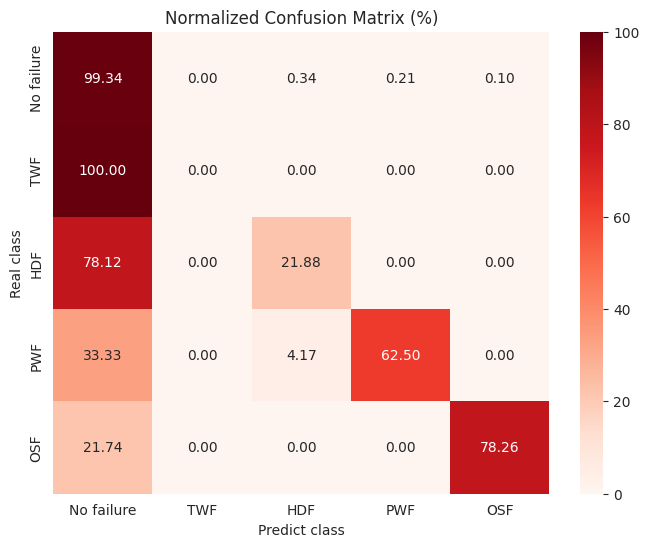

In [39]:
# Returns probabilities for each class
Y_pred_probs = model.predict(X_test)

# Selects the class with the highest probability as the final prediction
Y_pred = Y_pred_probs.argmax(axis=1)

Y_true = Y_test.values.argmax(axis=1)

labels = ['No failure', 'TWF', 'HDF', 'PWF', 'OSF']

report = classification_report(Y_true, Y_pred, target_names=labels)
print("\nRelatório de Classificação:")
print(report)

cm = confusion_matrix(Y_true, Y_pred)

# Normalization
cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Reds",
            xticklabels=labels, yticklabels=labels)

plt.title("Normalized Confusion Matrix (%)")
plt.xlabel("Predict class")
plt.ylabel("Real class")
plt.show()

**ANALYSIS QUESTION** What do you observe? What can you conclude?

As expected, the model tends to choose the non-failure label. By analyzing the loss and accuracy graphs, one can believe that the model returned good results, but by analyzing the confusion matrix one can see that in most cases it opts for the non-failure label, as already mentioned, the large number of non-failure label samples makes the error low.
This discrepancy in the dataset means that minority classes such as TWF are virtually unrecognizable.

## **3- Train model With balancing the dataset**

---

 Methods for rebalancing a dataset:


*   Use oversampling techniques (e.g., SMOTE) to generate synthetic data for minority classes


> https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html



*   Apply undersampling techniques (e.g., random undersampling, Tomek Links, Edited Nearest Neighbors) to reduce the majority class size



> https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html



*   Use class weighting during model training to penalize errors on minority classes



> https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=fr


**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [40]:
# Undersampling: reduces the number of samples from the majority class
undersampler = RandomUnderSampler(sampling_strategy=0.3, random_state=42)
X_resampled, y_no_failure = undersampler.fit_resample(X, Y['No failure'])

selected_indices = y_no_failure.index
Y_resampled = Y.iloc[selected_indices].copy()

Y_resampled = Y_resampled.apply(lambda row: (row == 1).astype(int), axis=1)

# Splits the balanced data into training and test
X_train_under, X_test_under, Y_train_under, Y_test_under = train_test_split(
    X_resampled, Y_resampled, test_size=0.2, random_state=42,
    stratify=Y_resampled.values.argmax(axis=1)
)

# Calculates class weights
y_integers = Y_train_under.values.argmax(axis=1)
classes = np.unique(y_integers)

class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_integers)
class_weight_dict = {i: weight for i, weight in zip(classes, class_weights)}

print("class_weight:", class_weight_dict)

class_weight: {0: 0.2601466992665037, 1: 6.08, 2: 2.503529411764706, 3: 3.325, 4: 3.432258064516129}


**ANALYSIS QUESTION:** Explain the choices you made to balance the dataset.

To balance the dataset, RandomUnderSampler was used to reduce the number of samples from the majority class ("No failure"). This class was reduced by 30% in relation to the other classes.

We also used weights for each class with compute_class_weight. We chose to use this method because even though we reduced the majority class, the other classes differ from each other. The TWF class, for example, has fewer samples, so it receives a higher weight.

**QUESTION:** Code below the model architecture


**TIP:** It could be interesting to keep it the same as before

In [41]:
# Same model structure but with less dropout and no BatchNormalization in the second layer
model = Sequential([
    Dense(64, kernel_regularizer=l2(0.01), input_shape=(X_train_under.shape[1],)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.2),

    Dense(32, kernel_regularizer=l2(0.01)),
    LeakyReLU(),
    Dropout(0.2),

    Dense(5, activation='softmax')
])

model.compile(
    optimizer=AdamW(learning_rate=0.001, weight_decay=0.02),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 64)                576       
                                                                 
 batch_normalization_8 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 64)                0         
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 32)                0         
                                                      

**QUESTION** Code below the algorithms allowing to train model


Epoch 1/50
17/17 [==============================] - 2s 17ms/step - loss: 2.1534 - accuracy: 0.1664 - val_loss: 2.1902 - val_accuracy: 0.0752 - lr: 0.0010
Epoch 2/50
17/17 [==============================] - 0s 5ms/step - loss: 1.8508 - accuracy: 0.2566 - val_loss: 2.1483 - val_accuracy: 0.0940 - lr: 0.0010
Epoch 3/50
17/17 [==============================] - 0s 5ms/step - loss: 1.6793 - accuracy: 0.3534 - val_loss: 2.1101 - val_accuracy: 0.1203 - lr: 0.0010
Epoch 4/50
17/17 [==============================] - 0s 5ms/step - loss: 1.5855 - accuracy: 0.3806 - val_loss: 2.0750 - val_accuracy: 0.1541 - lr: 0.0010
Epoch 5/50
17/17 [==============================] - 0s 5ms/step - loss: 1.4356 - accuracy: 0.4314 - val_loss: 2.0239 - val_accuracy: 0.2444 - lr: 0.0010
Epoch 6/50
17/17 [==============================] - 0s 5ms/step - loss: 1.3441 - accuracy: 0.4953 - val_loss: 1.9758 - val_accuracy: 0.3158 - lr: 0.0010
Epoch 7/50
17/17 [==============================] - 0s 5ms/step - loss: 1.2658 - 

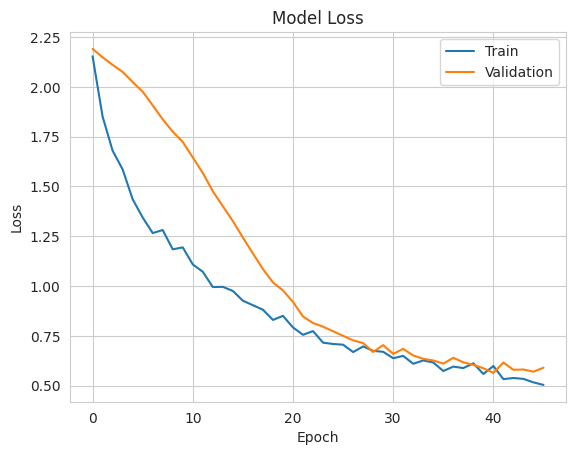

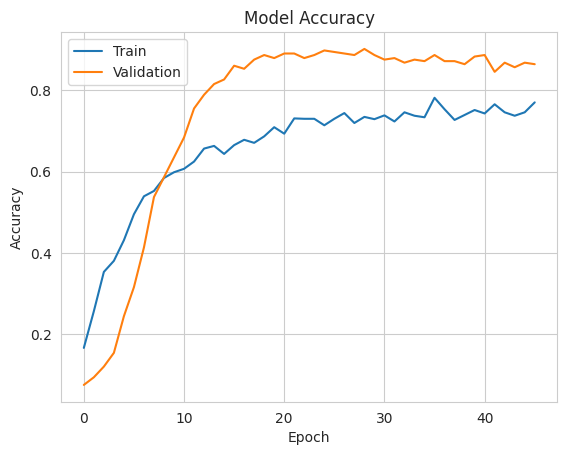

In [42]:
# Same structure as before
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1)

history = model.fit(
    X_train_under,
    Y_train_under,
    validation_data=(X_test_under, Y_test_under),
    epochs=50,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

def plot_metric(history, metric, title, ylabel, loc='upper left'):
    if metric in history.history:
        plt.plot(history.history[metric], label='Train')
    if f'val_{metric}' in history.history:
        plt.plot(history.history[f'val_{metric}'], label='Validation')

    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend(loc=loc)
    plt.show()

plot_metric(history, 'loss', 'Model Loss', 'Loss', loc='upper right')
plot_metric(history, 'accuracy', 'Model Accuracy', 'Accuracy')

# Saves test data for use in STM32 inference
np.save('X_test_labels.npy', X_test_under)
Y_test_under = Y_test_under.astype(np.float32)
np.save('Y_test_labels.npy', Y_test_under)

# Save the trained model
model.save('model_test.h5')


**QUESTION** Plot the confusion matrix and the classification report

9/9 [==============================] - 0s 2ms/step

Classification Report:
              precision    recall  f1-score   support

  No failure       0.98      0.88      0.93       205
         TWF       0.24      0.62      0.34         8
         HDF       0.95      0.90      0.93        21
         PWF       0.80      1.00      0.89        16
         OSF       0.71      0.94      0.81        16

    accuracy                           0.89       266
   macro avg       0.74      0.87      0.78       266
weighted avg       0.93      0.89      0.90       266



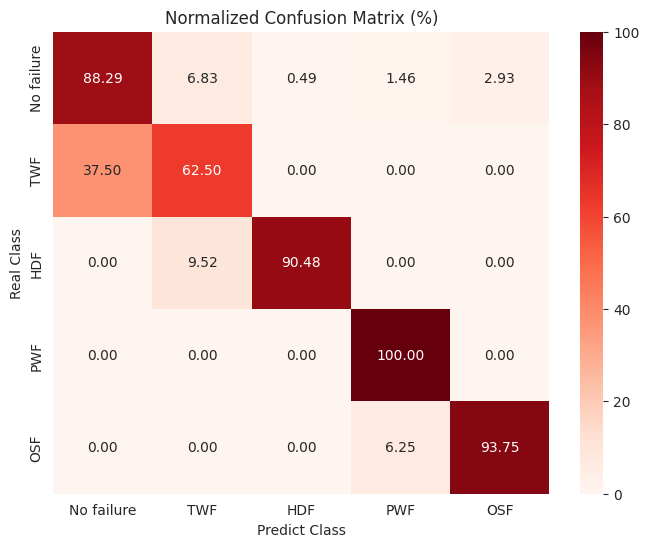

In [43]:
# Same structure as before
Y_pred_probs = model.predict(X_test_under)

Y_pred = Y_pred_probs.argmax(axis=1)

Y_true = Y_test_under.values.argmax(axis=1)

labels = ['No failure', 'TWF', 'HDF', 'PWF', 'OSF']

report = classification_report(Y_true, Y_pred, target_names=labels)
print("\nClassification Report:")
print(report)

cm = confusion_matrix(Y_true, Y_pred)

cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Reds",
            xticklabels=labels, yticklabels=labels)

plt.title("Normalized Confusion Matrix (%)")
plt.xlabel("Predict Class")
plt.ylabel("Real Class")
plt.show()

**ANALYSIS QUESTION** What do you observe? What can you conclude?

The final model showed a more balanced performance between the different classes, a notable evolution compared to the previous model.

The two balancing techniques made the model capable of identifying the minority classes, however, even after applying the weights to the classes, there is still a tendency for the classes to have majority fault types. For the TWF class, for example, it was possible to achieve an accuracy of approximately 30%, which is far from optimal, but better than the previous model.

Finally, we can say that this model manages to predict the different types of faults with a high level of accuracy and balance.